In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import cPickle as pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imread
from scipy.misc import imresize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input, ZeroPadding2D,merge,Lambda
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.optimizers import SGD
from keras import backend as K
from keras.engine import Layer
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from keras.layers.core import  Lambda
from keras.regularizers import l2
#}

Using Theano backend.


In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        img = imread(im_path, mode='RGB')
        #print im_path
        #print img.shape
        if img_size:
            img = imresize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print im_path
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [4]:
#Helper function to normalization across channels
K.set_image_dim_ordering('th')
def crosschannelnormalization(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        if K.image_dim_ordering()=='tf':
            b, r, c, ch = X.get_shape()
        else:
            b, ch, r, c = X.shape

        half = n // 2
        square = K.square(X)
        scale = k
        if K.image_dim_ordering() == 'th':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0,0),(half,half)))
            extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
            for i in range(n):
                scale += alpha * extra_channels[:, i:i+ch, :, :]
        if K.image_dim_ordering() == 'tf':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 3, 1, 2)), (half, 0))
            extra_channels = K.permute_dimensions(extra_channels, (0, 2, 3, 1))
            for i in range(n):
                scale += alpha * extra_channels[:, :, :, i:i+int(ch)]
        scale = scale ** beta
        return X / scale


    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [5]:
#Helper Function to split tensor
def splittensor(axis=1, ratio_split=1, id_split=0, **kwargs):
    def f(X):
        div = K.shape(X)[axis] // ratio_split

        if axis == 0:
            output = X[id_split*div:(id_split+1)*div, :, :, :]
        elif axis == 1:
            output = X[:, id_split*div:(id_split+1)*div, :, :]
        elif axis == 2:
            output = X[:, :, id_split*div:(id_split+1)*div, :]
        elif axis == 3:
            output = X[:, :, :, id_split*div:(id_split+1)*div]
        else:
            raise ValueError("This axis is not possible")
        return output

    def g(input_shape):
        output_shape = list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)


    return Lambda(f, output_shape=lambda input_shape: g(input_shape), **kwargs)

In [6]:
#Alexnet layer architecture class
def AlexNet(img_shape=(3, 227, 227), n_classes=1000, l2_reg=0.,weights_path=None):

    dim_ordering = K.image_dim_ordering()
    print dim_ordering
    if dim_ordering == 'th':
        batch_index = 0
        channel_index = 1
        row_index = 2
        col_index = 3
    if dim_ordering == 'tf':
        batch_index = 0
        channel_index = 3
        row_index = 1
        col_index = 2

    inputs = Input(img_shape)

    conv_1 = Convolution2D(96, 11, 11, subsample=(4, 4), activation='relu',
                           name='conv_1', W_regularizer=l2(l2_reg))(inputs)

    conv_1_mask = np.ones(shape=((96, 55, 55)))
    conv_1_mask  = K.variable(conv_1_mask)
    conv_1_lambda = Lambda(lambda x: x * conv_1_mask)(conv_1)

    conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1_lambda)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2, 2))(conv_2)
    conv_2 = merge([
        Convolution2D(128, 5, 5, activation="relu", name='conv_2_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_2)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_2")

    conv_2_mask = np.ones(shape=((256, 27, 27)))
    conv_2_mask = K.variable(conv_2_mask)
    conv_2_lambda = Lambda(lambda x: x * conv_2_mask)(conv_2)

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2_lambda)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Convolution2D(384, 3, 3, activation='relu', name='conv_3',
                           W_regularizer=l2(l2_reg))(conv_3)

    conv_3_mask = np.ones(shape=((384, 13, 13)))
    conv_3_mask = K.variable(conv_3_mask)
    conv_3_lambda = Lambda(lambda x: x * conv_3_mask)(conv_3)

    conv_4 = ZeroPadding2D((1, 1))(conv_3_lambda)
    conv_4 = merge([
        Convolution2D(192, 3, 3, activation="relu", name='conv_4_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_4)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_4")

    conv_4_mask = np.ones(shape=((384, 13, 13)))
    conv_4_mask = K.variable(conv_4_mask)
    conv_4_lambda = Lambda(lambda x: x * conv_4_mask)(conv_4)

    conv_5 = ZeroPadding2D((1, 1))(conv_4_lambda)
    conv_5 = merge([
        Convolution2D(128, 3, 3, activation="relu", name='conv_5_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_5)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_5")

    conv_5_mask = np.ones(shape=((256, 13, 13)))
    conv_5_mask = K.variable(conv_5_mask)
    conv_5_lambda = Lambda(lambda x: x * conv_5_mask)(conv_5)

    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name="convpool_5")(conv_5_lambda)

    dense_1 = Flatten(name="flatten")(dense_1)
    dense_1 = Dense(4096, activation='relu', name='dense_1',
                    W_regularizer=l2(l2_reg))(dense_1)

    dense_1_mask = np.ones(shape=((4096,)))
    dense_1_mask = K.variable(dense_1_mask)
    dense_1_lambda = Lambda(lambda x: x * dense_1_mask)(dense_1)

    dense_2 = Dropout(0.5)(dense_1_lambda)
    dense_2 = Dense(4096, activation='relu', name='dense_2',
                    W_regularizer=l2(l2_reg))(dense_2)

    dense_2_mask = np.ones(shape=((4096,)))
    dense_2_mask = K.variable(dense_2_mask)
    dense_2_lambda = Lambda(lambda x: x * dense_2_mask)(dense_2)

    dense_3 = Dropout(0.5)(dense_2_lambda)
    if n_classes == 1000:
        dense_3 = Dense(n_classes, name='dense_3',
                        W_regularizer=l2(l2_reg))(dense_3)
        dense_3_mask = np.ones(shape=((1000,)))
        dense_3_mask = K.variable(dense_3_mask)
        dense_3_lambda = Lambda(lambda x: x * dense_3_mask)(dense_3)
    else:
        # We change the name so when loading the weights_file from a
        # Imagenet pretrained model does not crash
        dense_3 = Dense(n_classes, name='dense_3_new',
                        W_regularizer=l2(l2_reg))(dense_3)
        dense_3_mask = np.ones(shape=((1000,)))
        dense_3_mask = K.variable(dense_3_mask)
        dense_3_lambda = Lambda(lambda x: x * dense_3_mask)(dense_3)

    prediction = Activation("softmax", name="softmax")(dense_3_lambda)

    model = Model(input=inputs, output=prediction)
    if weights_path:
        model.load_weights(weights_path)

    return model

In [7]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:n_max_synsets]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
        print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids


In [15]:
#Some Config

p = 'animate'
url_path = '../../data/92_image/'+p+'/'

In [16]:
# Prepare the image list and pre-process them{
im_list = []
for i in os.listdir(url_path):
    if not i.startswith('~') and not i.startswith('.'):
        temp = i.split('.')[0]
        im_list.append(url_path+i)

im = preprocess_image_batch(im_list,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
#}


In [17]:
id_to_words(1)

u'goldfish, Carassius auratus'

In [18]:
# Model parmeters and running the model from the loaded weights{

out_r = []

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5")
model.compile(optimizer=sgd, loss='mse')

out = model.predict(im,batch_size=64)

predicted_valid_wids = []
for i in range(len(im_list)):
    print im_list[i], pprint_output(out[i])
    predicted_valid_wids.append(pprint_output(out[i]))
#}

th
../../data/92_image/animate/12.jpeg 2.71 : nematode, nematode worm, roundworm n01930112
2.01 : platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus n01873310
1.75 : sea lion n02077923
1.59 : plane, carpenter's plane, woodworking plane n03954731
1.23 : mink n02442845
1.13 : weasel n02441942
1.12 : nipple n03825788
1.04 : dugong, Dugong dugon n02074367
0.91 : clog, geta, patten, sabot n03047690
0.88 : tub, vat n04493381
['n01930112', 'n01873310', 'n02077923', 'n03954731', 'n02442845', 'n02441942', 'n03825788', 'n02074367', 'n03047690', 'n04493381']
2.71 : nematode, nematode worm, roundworm n01930112
2.01 : platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus n01873310
1.75 : sea lion n02077923
1.59 : plane, carpenter's plane, woodworking plane n03954731
1.23 : mink n02442845
1.13 : weasel n02441942
1.12 : nipple n03825788
1.04 : dugong, Dugong dugon n02074367
0.91 : clog, geta, patten, sabot n03047690
0.88 : tub, va

In [22]:
# Code snippet to get the activation values and saving information{
data = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
            data = np.append(data, temp)
    i += 1

fp.close()
with open('../../data/pkl/92_'+str(p)+'_test.pkl', 'wb') as f:
    pickle.dump(data, f)

conv_1 2 1 (48, 96, 55, 55) (96, 55, 55) (290400,)
conv_2_1 2 1 (48, 128, 27, 27) (128, 27, 27) (93312,)
conv_2_2 2 1 (48, 128, 27, 27) (128, 27, 27) (93312,)
conv_3 2 1 (48, 384, 13, 13) (384, 13, 13) (64896,)
conv_4_1 2 1 (48, 192, 13, 13) (192, 13, 13) (32448,)
conv_4_2 2 1 (48, 192, 13, 13) (192, 13, 13) (32448,)
conv_5_1 2 1 (48, 128, 13, 13) (128, 13, 13) (21632,)
conv_5_2 2 1 (48, 128, 13, 13) (128, 13, 13) (21632,)
dense_1 2 1 (48, 4096) (4096,) (4096,)
dense_2 2 1 (48, 4096) (4096,) (4096,)
dense_3 2 1 (48, 1000) (1000,) (1000,)


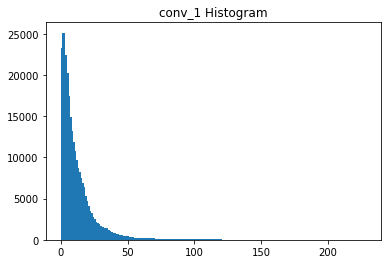

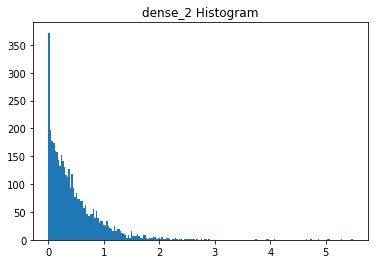

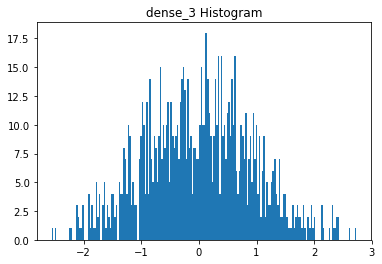

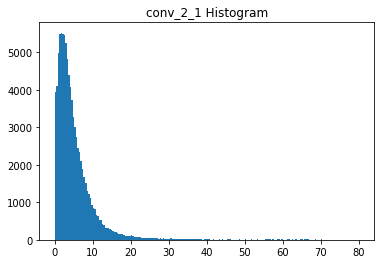

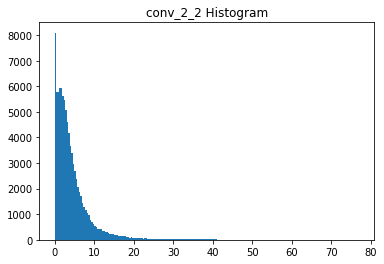

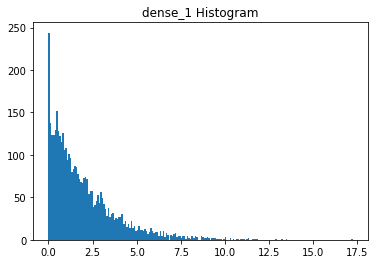

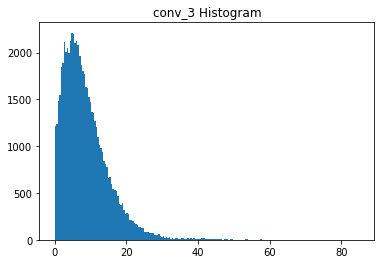

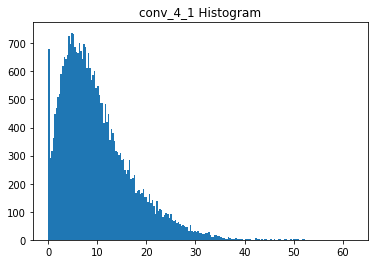

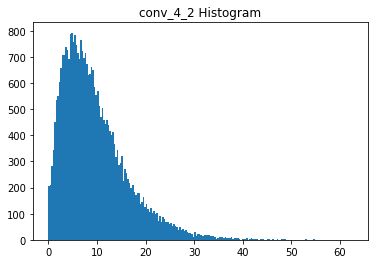

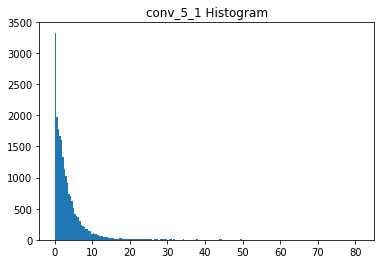

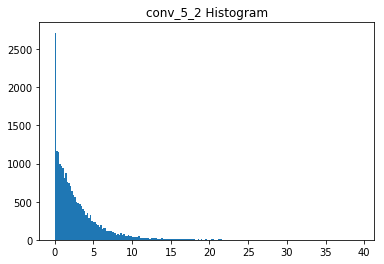

In [23]:
i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            plt.figure(i+1)
            plt.title(layer.name+' Histogram')
            plt.hist(temp,bins=200)
            #print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
            
    i += 1
